In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [44]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("so_data", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset))

In [45]:
os.listdir(dataset_dir)

['train', 'README.md', 'so_data.tar.gz', 'test']

In [46]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'python', 'javascript']

In [48]:
sample_file = os.path.join(train_dir, 'java/0.txt')
with open(sample_file) as f:
  print(f.read())

"how to download .msi file in blank i want to download .msi file using blank.  i have tried to download file using following code..printwriter out = null;.fileinputstream filetodownload = null;.bufferedreader bufferedreader = null;.try {.        out = response.getwriter();.        filetodownload = new fileinputstream(download_directory + file_name);.        bufferedreader = new bufferedreader(new inputstreamreader(filetodownload));..        //response.setcontenttype(""application/text"");.        //response.setcontenttype(""application/x-msi"");.        //response.setcontenttype(""application/msi"");.        //response.setcontenttype(""octet-stream"");.        response.setcontenttype(""application/octet-stream"");.        //response.setcontenttype(""application/x-7z-compressed"");.        //response.setcontenttype(""application/zip"");.        response.setheader(""content-disposition"",""attachment; filename="" +file_name );.        response.setcontentlength(filetodownload.available())

In [50]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [51]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [52]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to csharp
Label 1 corresponds to java


In [53]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [54]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [55]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [56]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [57]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [58]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [60]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Question", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized question", vectorize_text(first_review, first_label))

Question tf.Tensor(b'"function expected error in blank for dynamically created check box when it is clicked i want to grab the attribute value.it is working in ie 8,9,10 but not working in ie 11,chrome shows function expected error..&lt;input type=checkbox checked=\'checked\' id=\'symptomfailurecodeid\' tabindex=\'54\' style=\'cursor:pointer;\' onclick=chkclickevt(this);  failurecodeid=""1"" &gt;...function chkclickevt(obj) { .    alert(obj.attributes(""failurecodeid""));.}"\n', shape=(), dtype=string)
Label javascript
Vectorized question (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  38,  450,   65,    7,   16,   12,  892,  265,  186,  451,   44,
          11,    6,  685,    3,   46,    4, 2062,    2,  485,    1,    6,
         158,    7,  479,    1,   26,   20,  158,    7,  479,    1,  502,
          38,  450,    1, 1767, 1763,    1,    1,    1,    1,    1,    1,
           1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0

In [61]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [62]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [63]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [64]:
embedding_dim = 16

In [67]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

In [68]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=["accuracy"]
)

In [69]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [70]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 3s 12ms/step - loss: 1.3782 - accuracy: 0.3420 - val_loss: 1.3678 - val_accuracy: 0.4588
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 1.3500 - accuracy: 0.4636 - val_loss: 1.3315 - val_accuracy: 0.4994
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 1.3024 - accuracy: 0.5219 - val_loss: 1.2754 - val_accuracy: 0.5619
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 1.2369 - accuracy: 0.5822 - val_loss: 1.2054 - val_accuracy: 0.6137
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 1.1606 - accuracy: 0.6345 - val_loss: 1.1301 - val_accuracy: 0.6569
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 1.0828 - accuracy: 0.6786 - val_loss: 1.0575 - val_accuracy: 0.6913
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 1.0108 - accuracy: 0.7072 - val_loss: 0.9908 - val_accuracy: 0.7175
Epoch

In [71]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 2s 8ms/step - loss: 0.8679 - accuracy: 0.7360
Loss:  0.8678612112998962
Accuracy:  0.7360000014305115


In [72]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

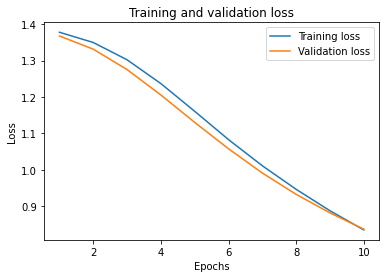

In [73]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

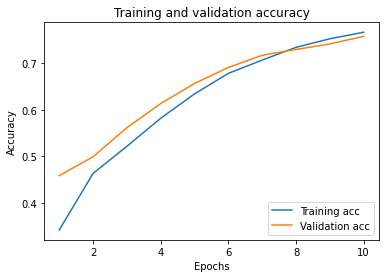

In [74]:
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [82]:
examples = [
  """I have two Python scripts. One uses the Urllib2 library and one uses the Requests library.

I have found Requests easier to implement, but I can't find an equivalent for urlib2's read() function. For example:

...
response = url.urlopen(req)
print response.geturl()
print response.getcode()
data = response.read()
print data
Once I have built up my post url, data = response.read() gives me the content - I am trying to connect to a vcloud director api instance and the response shows the endpoints that I have access to. However if I use the Requests library as follows....."""
]

vec_examples = vectorize_layer(examples)

pred = model.predict(vec_examples)
print(pred)

import numpy as np
label_id = np.argmax(pred)
print(label_id)

print(raw_train_ds.class_names[label_id])

1/1 [==============================] - 0s 25ms/step
[[ 0.01382883 -0.2124146  -0.11360328  0.2962108 ]]
3
python
